In [1]:
import ROOT as rt

Welcome to JupyROOT 6.28/00


In [2]:
load_path = "workspace/workspace_ggh_All_Zfit_no_e_cut_UL_calib_cat20.root"

In [3]:
file = rt.TFile.Open(load_path)

In [4]:
canvas = rt.TCanvas()
canvas.cd()
mass =  rt.RooRealVar("mh_ggh","mass (GeV)",100,81,101)
mass.setBins(100) # set bins to make fitting quicker 
frame = mass.frame()

In [5]:

bwWidth = rt.RooRealVar("bwz_Width" , "widthZ", 2.5, 0, 30)
bwmZ = rt.RooRealVar("bwz_mZ" , "mZ", 91.2, 90, 92)
sigma = rt.RooRealVar("sigma" , "sigma", 2, 0.0, 5.0)

bwWidth.setConstant(True)
# bwmZ.setConstant(True)
# sigma.setConstant(True)
#bwmZ.setConstant(True)

model1 = rt.RooVoigtian("Voigtian" , "Voigtian",mass, bwmZ, bwWidth, sigma)

exp_coeff = rt.RooRealVar("exp_coeff", "exp_coeff", 0.01, 0.00000001, 1) # positve coeff to get the peak shape we want 
# exp_coeff = rt.RooRealVar("exp_coeff", "exp_coeff", -0.01, -1, -0.00000001)
shift = rt.RooRealVar("shift", "Offset", 85, 75, 105)
shifted_mass = rt.RooFormulaVar("shifted_mass", "@0-@1", rt.RooArgList(mass, shift))
model2_1 = rt.RooExponential("Exponential", "Exponential", shifted_mass,exp_coeff)

center = rt.RooRealVar("center" , "center", 91.2, 75, 105)
erfc_coeff = rt.RooRealVar("erfc_coeff" , "erfc_coeff", 0.01, 0, 1.5)
erfc_in = rt.RooFormulaVar("erfc_in", "(@0 - @2) * @1", rt.RooArgList(mass, erfc_coeff, center)) 
model2_2 = rt.RooFit.bindPdf("erfc", rt.TMath.Erfc, erfc_in)


model2 = rt.RooProdPdf("erfc_exp", "erfc_exp", rt.RooArgList(model2_1, model2_2))
sigfrac = rt.RooRealVar("sigfrac", "sigfrac", 0.9, 0, 1.0)
model3 = rt.RooAddPdf("model3", "model3", rt.RooArgList(model1, model2),rt.RooArgList(sigfrac))

# bkgfrac = rt.RooFormulaVar("bkgfrac", "(1 - @0)", rt.RooArgList(sigfrac)) 
# dummy_bkg_var = rt.RooProdPdf("dummy_bkg_var", "dummy_bkg_var", rt.RooArgList(bkgfrac, model2))  # pdf model just for plotting bkg on the plot with bkgfrac
dummy_bkg_var = rt.RooGenericPdf("dummy_bkg_var", "dummy_bkg_var", "(1 - @0) * @1", rt.RooArgList(sigfrac,model2))

In [6]:
import time

start = time.time()
roo_dataset = file.w.data("data_Zfit_no_e_cut_UL_calib_cat20")
roo_hist = rt.RooDataHist("data_hist","binned version of roo_dataset", rt.RooArgSet(mass), roo_dataset)  # copies binning from mass variable

rt.EnableImplicitMT()
model3.fitTo(roo_hist, rt.RooFit.BatchMode("cpu"))


end = time.time()
print(f"fitting elapsed time: {end - start}")

fitting elapsed time: 1.1603357791900635
[#1] INFO:Fitting -- RooAbsPdf::fitTo(model3) fixing normalization set for coefficient determination to observables in data
[#1] INFO:Fitting -- using CPU computation library compiled with -mavx2
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_model3_data_hist) Summation contains a RooNLLVar, using its error level
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 bwz_mZ       9.12000e+01  2.00000e-01    9.00000e+01  9.20000e+01
     2 center       9.12000e+01  3.00000e+00    7.50000e+01  1.05000e+02
     3 erfc_coeff   1.00000e-02  5.00000e-03    0.00000e+00  1.50000e+00
     4 exp_coeff    1.00000e-02  5.00000e-03    1.00000e-08  1.00000e+00
     5 shift        8.50000e+01  3.00000e+00    7.50000e+01  1.050

Warning in <RTaskArenaWrapper>: CPU Bandwith Control Active. Proceeding with 64 threads accordingly


[#1] INFO:NumericIntegration -- RooRealIntegral::init(Voigtian_Int[mh_ggh]) using numeric integrator RooIntegrator1D to calculate Int(mh_ggh)
[#1] INFO:NumericIntegration -- RooRealIntegral::init([Exponential_X_erfc]_Norm[mh_ggh]_denominator_Int[mh_ggh]) using numeric integrator RooIntegrator1D to calculate Int(mh_ggh)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(Voigtian_Int[mh_ggh]) using numeric integrator RooIntegrator1D to calculate Int(mh_ggh)
[#1] INFO:NumericIntegration -- RooRealIntegral::init([Exponential_X_erfc]_Norm[mh_ggh]_denominator_Int[mh_ggh]) using numeric integrator RooIntegrator1D to calculate Int(mh_ggh)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(dummy_bkg_var_Int[mh_ggh]) using numeric integrator RooIntegrator1D to calculate Int(mh_ggh)
[#1] INFO:NumericIntegration -- RooRealIntegral::init([Exponential_X_erfc]_Norm[mh_ggh]_denominator_Int[mh_ggh]) using numeric integrator RooIntegrator1D to calculate Int(mh_ggh)


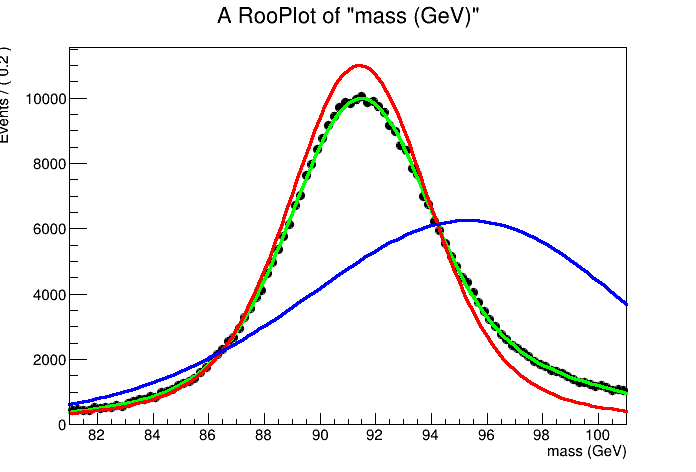

In [7]:
# file.w.pdf("Voigtian_ggh_All").plotOn(frame)

file.w.data("data_Zfit_no_e_cut_UL_calib_cat20").plotOn(frame)
model3.plotOn(frame, rt.RooFit.LineColor(rt.kGreen))
model1.plotOn(frame, rt.RooFit.LineColor(rt.kRed))
model2.plotOn(frame, rt.RooFit.LineColor(rt.kBlack))
dummy_bkg_var.plotOn(frame, rt.RooFit.LineColor(rt.kBlue))

frame.Draw()
canvas.Update()
canvas.Draw()
